# CSU EDA v0.2
- 2022-01-01 to present (starts on a saturday)
- DMA split 3 ways:
    - awareness_markets: Orlando, Jacksonville, Greenville, SC and Birmingham
    - Mobile (DMA)
    - all other DMA
- it's been decided to only use cohort view (KPI by Lead date)
- Media Data (set up by Mike for Geo): Bing, Google, Meta, TikTok, TTD, LinkedIn
    - what to do with linkedIn since it has no geo info???

In [29]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.precision', 2)
pd.set_option('display.float_format',  '{:,.2f}'.format)

In [30]:
kpi_raw = pd.read_csv('../data/CSU_KPI_raw_2022-01-01_2025-01-15.csv')
tiktok_raw = pd.read_csv('../data/CSU_data_tiktok_raw_2024-01-15.csv')
meta_raw = pd.read_csv('../data/CSU_data_meta_raw_2024-01-15.csv')
google_raw = pd.read_csv('../data/CSU_data_google_raw_2024-01-15.csv')
bing_raw = pd.read_csv('../data/CSU_data_bing_raw_2024-01-15.csv')
ttd_raw = pd.read_csv('../data/CSU_data_TTD_raw_2024-01-15.csv')
linkedin_raw = pd.read_csv('../data/CSU_data_linkedin_raw_2024-01-15.csv')

In [31]:
# list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'GREENWOOD-GREENVILLE', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM (ANN AND TUSC)']
list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM (ANN AND TUSC)']

df_kpi_full = kpi_raw.copy()
df_kpi_full['leaddate'] = pd.to_datetime(df_kpi_full['leaddate']).dt.normalize()
df_kpi_full['appdate'] = pd.to_datetime(df_kpi_full['appdate']).dt.normalize()
df_kpi_full['enrolldate'] = pd.to_datetime(df_kpi_full['enrolldate']).dt.normalize()
df_kpi_full['dma'] = None
df_kpi_full.loc[df_kpi_full['dmaname'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_kpi_full.loc[df_kpi_full['dmaname'].str.contains('MOBILE-PENSACOLA', na=False), 'dma'] = 'mobile'
df_kpi_full.loc[df_kpi_full['dma'].isna(), 'dma'] = 'other'
df_kpi_full = df_kpi_full.loc[df_kpi_full['leaddate'] < pd.Timestamp.today()].drop(['dmaname'], axis=1) 
df_kpi_full['channel'] = None
# df_kpi_full.loc[df_kpi_full['dw_vendor'] == 'ArcherOrg', 'channel'] = 'Organic'
# df_kpi_full.loc[df_kpi_full['dw_channel'].str.contains('Referral'), 'channel'] = 'Referral'
df_kpi_full.loc[df_kpi_full['dw_channel'].str.contains('PPL'), 'channel'] = 'PPL'
df_kpi_full.loc[df_kpi_full['channel'].isna(), 'channel'] = 'ALL(No PPL,Referral)' #NO PPL BUT Everything else
df_kpi_full = df_kpi_full.loc[df_kpi_full.leaddate < '2025-01-10'] ##keeping with saturday-friday

### Making cohort KPI data frame where all KPI are by the lead date (drop organic being separated, roll into ALL with referral)
df_kpi_cohort = df_kpi_full.loc[df_kpi_full.dma != 'mobile'].copy()
df_kpi_cohort = df_kpi_cohort.groupby(['leaddate', 'dma', 'channel'])[['n_lead', 'n_app', 'n_enroll']].agg('sum')
df_kpi_cohort = df_kpi_cohort.unstack(['dma', 'channel']).reorder_levels([1,2, 0], axis=1).sort_index(axis=1).fillna(0)

df_kpi_cohort_weekly = df_kpi_cohort.resample('W-Sat').sum()

df_kpi_cohort_monthly = df_kpi_cohort.resample('MS').sum()

C:\Users\twolf\AppData\Local\Temp\ipykernel_13536\1268115707.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_kpi_full.loc[df_kpi_full['dmaname'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'


In [32]:
df_kpi_full

,leaddate,appdate,enrolldate,n_lead,n_app,n_enroll,dw_vendor,dw_channel,dma,channel
0,2022-01-01,NaT,NaT,1,0,0,GoogleNonBrand,Search,other,"ALL(No PPL,Referral)"
1,2022-01-01,2023-05-08,2023-05-25,1,1,1,GoogleNonBrand,Search,other,"ALL(No PPL,Referral)"
2,2022-01-01,NaT,NaT,1,0,0,GoogleBrand,Search,other,"ALL(No PPL,Referral)"
3,2022-01-01,NaT,NaT,1,0,0,Facebook,Social,other,"ALL(No PPL,Referral)"
4,2022-01-01,NaT,NaT,0,0,0,Facebook,Social,other,"ALL(No PPL,Referral)"
...,...,...,...,...,...,...,...,...,...,...
275574,2025-01-09,NaT,NaT,1,0,0,HL,PPL,other,PPL
275575,2025-01-09,NaT,NaT,1,0,0,FacebookLF,Social,other,"ALL(No PPL,Referral)"
275576,2025-01-09,NaT,NaT,1,0,0,SEO,SEO,awareness,"ALL(No PPL,Referral)"
275577,2025-01-09,NaT,NaT,1,0,0,GoogleBrand,Search,other,"ALL(No PPL,Referral)"


In [33]:
df_kpi_cohort_monthly.head()

dma                   awareness                                        \
channel    ALL(No PPL,Referral)                   PPL                   
                          n_app n_enroll n_lead n_app n_enroll n_lead   
leaddate                                                                
2022-01-01                30.00    12.00 126.00  4.00     1.00  62.00   
2022-02-01                24.00    10.00 123.00  6.00     0.00  70.00   
2022-03-01                32.00    13.00 108.00  8.00     2.00  76.00   
2022-04-01                23.00     9.00 113.00  5.00     1.00  53.00   
2022-05-01                41.00    14.00 134.00  8.00     1.00  42.00   

dma                       other                                             
channel    ALL(No PPL,Referral)                      PPL                    
                          n_app n_enroll   n_lead  n_app n_enroll   n_lead  
leaddate                                                                    
2022-01-01               861.00   330.00 4,409.00 175.00    25.00 1,423.00  
2022-02-01               716.00   250.00 3,479.00 146.00    23.00 1,765.00  
2022-03-01               734.00   268.00 3,551.00 182.00    31.00 2,255.00  
2022-04-01               719.00   271.00 3,482.00 105.00    17.00 1,219.00  
2022-05-01               738.00   252.00 3,507.00 108.00    15.00 1,008.00

In [34]:
# list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'GREENWOOD-GREENVILLE, MS', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM, AL']
list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM, AL']

df_goo = google_raw.copy()
df_goo['Date'] = pd.to_datetime(df_goo['Date'])
df_goo['Metro area'] = df_goo['Metro area'].str.upper()
df_goo['dma'] = None
df_goo.loc[df_goo['Metro area'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_goo.loc[df_goo['Metro area'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_goo.loc[df_goo['dma'].isna(), 'dma'] = 'other'
df_goo = df_goo.loc[df_goo.dma != 'mobile']
df_goo['channel'] = None
df_goo.loc[df_goo['Brand'] == 'Brand', 'channel'] = 'SearchBrand'
df_goo.loc[df_goo['Campaign name'].str.contains('YouTube'), 'channel'] = 'YouTube'
df_goo.loc[df_goo['Campaign name'].str.contains('Display'), 'channel'] = 'Display'
df_goo.loc[df_goo['channel'].isna(), 'channel'] = 'SearchNonBrand' ###not certain if this is what we can make nonBrand
df_goo = df_goo.rename(columns={'Cost':'spend', 'Date':'date'})
df_goo = df_goo[['date', 'dma', 'channel', 'spend']]

In [35]:
df_goo

,date,dma,channel,spend
0,2022-07-01,other,SearchNonBrand,43.53
1,2022-07-02,other,SearchNonBrand,4.64
2,2022-07-02,other,SearchNonBrand,9.23
3,2022-07-02,other,SearchNonBrand,29.98
4,2022-07-03,other,SearchNonBrand,84.27
...,...,...,...,...
2464861,2022-06-28,other,Display,0.00
2464862,2022-06-29,other,Display,0.00
2464863,2022-06-30,other,Display,0.00
2464864,2022-06-30,other,Display,0.00


In [36]:
# list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'GREENWOOD-GREENVILLE, MS', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM']
list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM']

df_bing = bing_raw.copy()
df_bing['Date'] = pd.to_datetime(df_bing['Date'])
df_bing['Visitor metro area'] = df_bing['Visitor metro area'].str.upper()
df_bing['dma'] = None
df_bing.loc[df_bing['Visitor metro area'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_bing.loc[df_bing['Visitor metro area'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_bing = df_bing.loc[df_bing.dma != 'mobile']
df_bing.loc[df_bing['dma'].isna(), 'dma'] = 'other'
df_bing['channel'] = None
df_bing.loc[df_bing['Brand'] == 'Brand', 'channel'] = 'SearchBrand'
df_bing.loc[df_bing['Brand'] == 'Non Brand', 'channel'] = 'SearchNonBrand'
df_bing = df_bing.rename(columns={'Cost':'spend', 'Date':'date'})
df_bing = df_bing.groupby(['date', 'dma', 'channel'])['spend'].agg('sum').reset_index()

In [37]:
df_bing

,date,dma,channel,spend
0,2022-01-14,awareness,SearchBrand,91.48
1,2022-01-14,awareness,SearchNonBrand,13.86
2,2022-01-14,other,SearchBrand,"1,206.78"
3,2022-01-14,other,SearchNonBrand,319.97
4,2022-01-15,awareness,SearchBrand,36.33
...,...,...,...,...
4327,2024-12-30,other,SearchNonBrand,"2,147.94"
4328,2024-12-31,awareness,SearchBrand,77.26
4329,2024-12-31,awareness,SearchNonBrand,161.03
4330,2024-12-31,other,SearchBrand,"1,109.15"


In [38]:
# list_awareness = ['GREENVILLE - SPARTANBURG - ASHEVILLE - ANDERSON', 'JACKSONVILLE', 'GREENWOOD - GREENVILLE', 'ORLANDO - DAYTONA BEACH - MELBOURNE', 'BIRMINGHAM']
list_awareness = ['GREENVILLE - SPARTANBURG - ASHEVILLE - ANDERSON', 'JACKSONVILLE', 'ORLANDO - DAYTONA BEACH - MELBOURNE', 'BIRMINGHAM']

df_tiktok = tiktok_raw.copy()
df_tiktok['Date'] = pd.to_datetime(df_tiktok['Date'])
df_tiktok['DMA name'] = df_tiktok['DMA name'].str.upper()
df_tiktok['dma'] = None
df_tiktok.loc[df_tiktok['DMA name'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_tiktok.loc[df_tiktok['DMA name'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_tiktok = df_tiktok.loc[df_tiktok.dma != 'mobile']
df_tiktok.loc[df_tiktok['dma'].isna(), 'dma'] = 'other'
df_tiktok['channel'] = 'TikTok'
df_tiktok = df_tiktok.rename(columns={'Cost':'spend', 'Date':'date'})
df_tiktok = df_tiktok[['date', 'dma', 'channel', 'spend']]

In [39]:
df_tiktok

,date,dma,channel,spend
0,2024-02-03,other,TikTok,7.00
1,2024-02-21,other,TikTok,7.00
2,2024-02-24,other,TikTok,7.00
3,2024-02-05,other,TikTok,7.25
4,2024-04-15,other,TikTok,7.50
...,...,...,...,...
335089,2023-11-23,other,TikTok,1.81
335090,2023-11-30,other,TikTok,1.81
335091,2023-12-03,other,TikTok,1.81
335092,2023-12-17,other,TikTok,1.81


In [40]:
# list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'GREENWOOD-GREENVILLE', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM']
list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM']

df_meta = meta_raw.copy()
df_meta['Date'] = pd.to_datetime(df_meta['Date'])
df_meta['DMA'] = df_meta['DMA'].str.upper()
df_meta['dma'] = None
df_meta.loc[df_meta['DMA'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_meta.loc[df_meta['DMA'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_meta = df_meta.loc[df_meta.dma != 'mobile']
df_meta.loc[df_meta['dma'].isna(), 'dma'] = 'other'
df_meta['channel'] = 'Meta'
df_meta = df_meta.rename(columns={'Cost':'spend', 'Date':'date'})
df_meta = df_meta[['date', 'dma', 'channel', 'spend']]

In [41]:
df_meta

,date,dma,channel,spend
0,2022-07-01,other,Meta,0.65
1,2022-07-01,other,Meta,1.53
2,2022-07-01,other,Meta,0.69
3,2022-07-01,awareness,Meta,3.55
4,2022-07-02,other,Meta,1.22
...,...,...,...,...
1733750,2024-08-25,other,Meta,0.07
1733751,2024-10-23,other,Meta,0.14
1733752,2024-12-29,other,Meta,0.14
1733753,2024-11-17,other,Meta,0.14


In [42]:
# list_awareness = ['GREENVILLE-SPARTANBURG SC-ASHEVILLE NC-ANDERSON SC', 'GREENWOOD-GREENVILLE', 'JACKSONVILLE', 'ORLANDO-DAYTONA BEACH-MELBOURNE', 'BIRMINGHAM']
list_awareness = ['GREENVILLE-SPARTANBURG SC-ASHEVILLE NC-ANDERSON SC', 'JACKSONVILLE', 'ORLANDO-DAYTONA BEACH-MELBOURNE', 'BIRMINGHAM']

df_ttd = ttd_raw.copy()
df_ttd['record_date'] = pd.to_datetime(df_ttd['record_date'])
df_ttd['metro'] = df_ttd['metro'].str.upper()
df_ttd['dma'] = None
df_ttd.loc[df_ttd['metro'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_ttd.loc[df_ttd['metro'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_ttd = df_ttd.loc[df_ttd.dma != 'mobile']
df_ttd.loc[df_ttd['dma'].isna(), 'dma'] = 'other'
df_ttd.loc[df_ttd['campaign_name'].str.contains('DOOH'), 'channel'] = 'DOOH'
df_ttd.loc[df_ttd['campaign_name'].str.contains('|'.join(['CTV', 'OTT'])), 'channel'] = 'CTV/OTT'
df_ttd.loc[df_ttd['campaign_name'].str.contains('Audio'), 'channel'] = 'Digital Radio'
df_ttd = df_ttd.rename(columns={'cost':'spend', 'record_date':'date'})
df_ttd = df_ttd[['date', 'dma', 'channel', 'spend']]

In [43]:
df_ttd

,date,dma,channel,spend
0,2024-06-24,awareness,DOOH,"1,769.11"
1,2024-06-25,awareness,DOOH,"1,269.76"
2,2024-06-26,awareness,DOOH,"1,326.08"
3,2024-06-27,awareness,DOOH,"1,357.42"
4,2024-06-28,awareness,DOOH,"1,414.66"
...,...,...,...,...
10423,2024-09-12,awareness,CTV/OTT,0.00
10424,2024-09-13,awareness,CTV/OTT,0.00
10425,2024-09-14,awareness,CTV/OTT,0.00
10426,2024-09-15,awareness,CTV/OTT,0.00


In [44]:
 ### LinkedIn has no geo splitting from platform
df_li = linkedin_raw.copy()
df_li = df_li.rename(columns={'record_date':'date', 'cost':'spend'})
df_li['date'] = pd.to_datetime(df_li['date'])
df_li = df_li.groupby('date')['spend'].agg('sum').reset_index()
df_li['channel'] = 'LinkedIn'
df_li['dma'] = 'unknown'

In [45]:
df_li

,date,spend,channel,dma
0,2023-10-26,248.97,LinkedIn,unknown
1,2023-10-27,251.49,LinkedIn,unknown
2,2023-10-28,251.25,LinkedIn,unknown
3,2023-10-29,250.15,LinkedIn,unknown
4,2023-10-30,250.13,LinkedIn,unknown
...,...,...,...,...
443,2025-01-11,743.54,LinkedIn,unknown
444,2025-01-12,620.89,LinkedIn,unknown
445,2025-01-13,888.96,LinkedIn,unknown
446,2025-01-14,"1,227.14",LinkedIn,unknown


In [46]:
df_spend = pd.concat([df_bing, df_goo, df_meta, df_tiktok, df_ttd, df_li])
df_spend = df_spend.groupby(['date', 'dma', 'channel'])['spend'].agg('sum')
df_spend_daily = df_spend.reset_index().copy()

df_spend_weekly = df_spend.unstack(['dma', 'channel']).sort_index(axis=1).fillna(0)
df_spend_weekly = df_spend_weekly.resample('W-Sat').sum()

df_spend_monthly = df_spend.unstack(['dma', 'channel']).sort_index(axis=1).fillna(0)
df_spend_monthly = df_spend_monthly.resample('MS').sum()

In [47]:
today = pd.Timestamp.today().date()
today = pd.to_datetime(today).strftime('%Y-%m-%d')

### saving different df's to a single sheet
with pd.ExcelWriter(f'../data/csu_final_data_{today}.xlsx') as writer:
    df_kpi_full.to_excel(writer, sheet_name='KPI_full', index=True, merge_cells=True)
    df_kpi_cohort.to_excel(writer, sheet_name='KPI_cohort_daily', index=True, merge_cells=True)
    df_kpi_cohort_weekly.to_excel(writer, sheet_name='KPI_cohort_weekly', index=True, merge_cells=True)
    df_kpi_cohort_monthly.to_excel(writer, sheet_name='KPI_cohort_monthly', index=True, merge_cells=True)
    df_spend_daily.to_excel(writer, sheet_name='spend_daily', index=True, merge_cells=True)  
    df_spend_weekly.to_excel(writer, sheet_name='spend_weekly', index=True, merge_cells=True)
    df_spend_monthly.to_excel(writer, sheet_name='spend_monthly', index=True, merge_cells=True)              

# EDA

In [48]:
df_kpi_full[['n_lead', 'n_app', 'n_enroll']].sum()

n_lead      226548
n_app        46373
n_enroll     16703
dtype: int64

In [49]:
df_kpi_full.groupby('dma')[['n_lead', 'n_app', 'n_enroll']].sum()

,n_lead,n_app,n_enroll
dma,,,
awareness,7375,1621,605
mobile,4656,1432,590
other,214517,43320,15508


In [50]:
df_kpi_full.groupby(['dma', 'channel'])[['n_lead', 'n_app', 'n_enroll']].sum()

n_lead  n_app  n_enroll
dma       channel                                      
awareness ALL(No PPL,Referral)    6258   1464       570
          PPL                     1117    157        35
mobile    ALL(No PPL,Referral)    4326   1355       576
          PPL                      330     77        14
other     ALL(No PPL,Referral)  180748  38119     14649
          PPL                    33769   5201       859

In [51]:
df_spend_daily.groupby('dma')['spend'].sum() #unknown is LinkedIn only

dma
awareness    2,670,416.50
other       14,590,731.59
unknown        271,024.38
Name: spend, dtype: float64

In [52]:
df_spend_daily.groupby(['dma', 'channel'])['spend'].sum()

dma        channel       
awareness  CTV/OTT            884,816.67
           DOOH               374,367.19
           Digital Radio      308,823.11
           Display             13,527.92
           Meta                96,918.44
           SearchBrand        212,967.88
           SearchNonBrand     394,884.27
           TikTok              16,622.55
           YouTube            367,488.47
other      CTV/OTT            222,576.80
           DOOH               143,288.29
           Digital Radio       92,660.79
           Display            322,444.35
           Meta             1,854,011.74
           SearchBrand      3,360,269.17
           SearchNonBrand   7,891,104.35
           TikTok             386,326.71
           YouTube            318,049.39
unknown    LinkedIn           271,024.38
Name: spend, dtype: float64

<AxesSubplot: xlabel='date'>

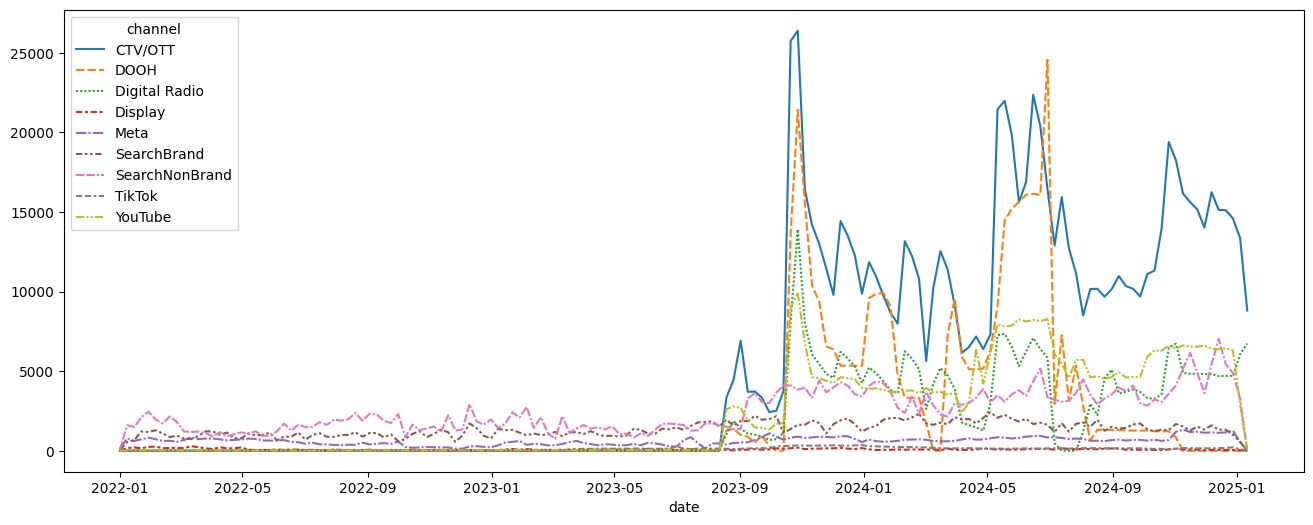

In [53]:
df_gr = df_spend_weekly.loc[:,'awareness'][:-1]
plt.figure(figsize=(16,6))
sns.lineplot(data=df_gr)

<AxesSubplot: xlabel='date'>

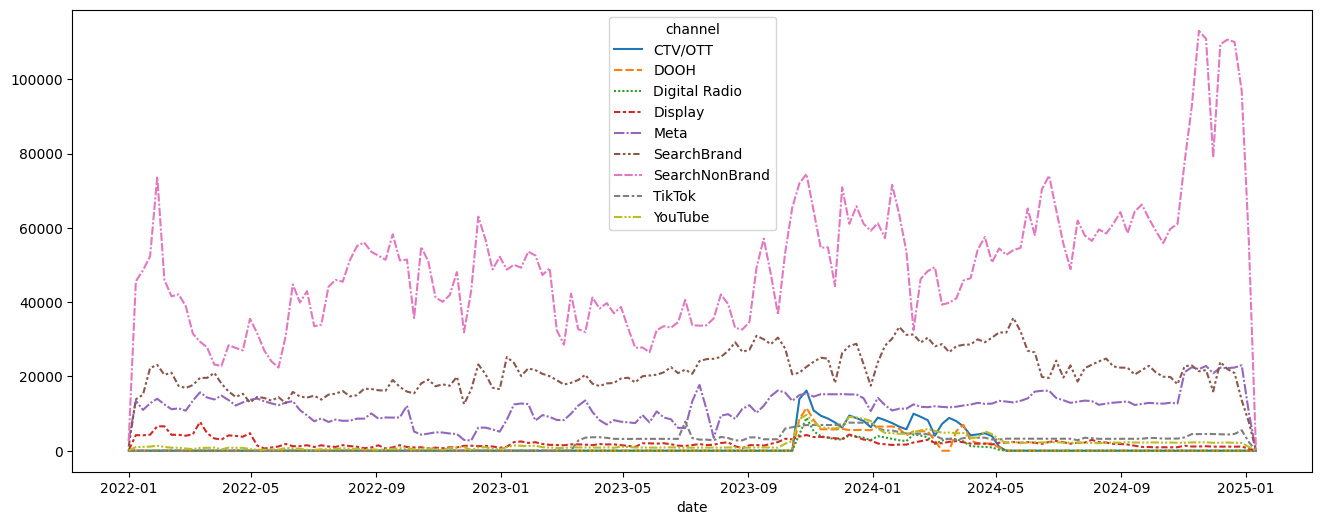

In [54]:
df_gr = df_spend_weekly.loc[:,'other'][:-1]
plt.figure(figsize=(16,6))

sns.lineplot(data=df_gr)

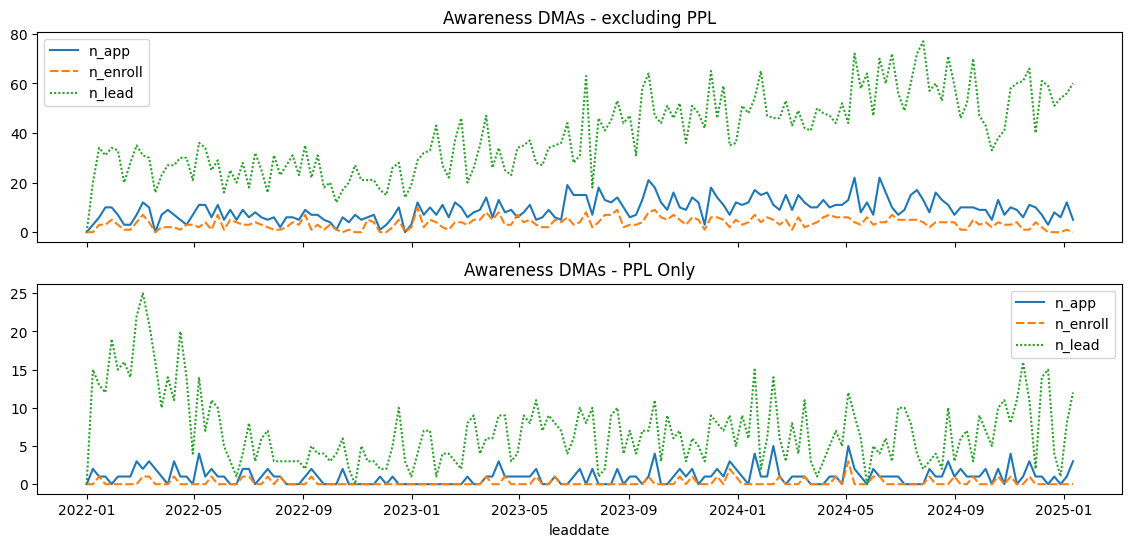

In [55]:
fig, axes = plt.subplots(2,1, figsize=(14,6), sharex=True)
sns.lineplot(data=df_kpi_cohort_weekly.loc[:, ('awareness', 'ALL(No PPL,Referral)')], ax=axes[0])
sns.lineplot(data=df_kpi_cohort_weekly.loc[:, ('awareness', 'PPL')], ax=axes[1])
axes[0].set_title('Awareness DMAs - excluding PPL')
axes[1].set_title('Awareness DMAs - PPL Only');

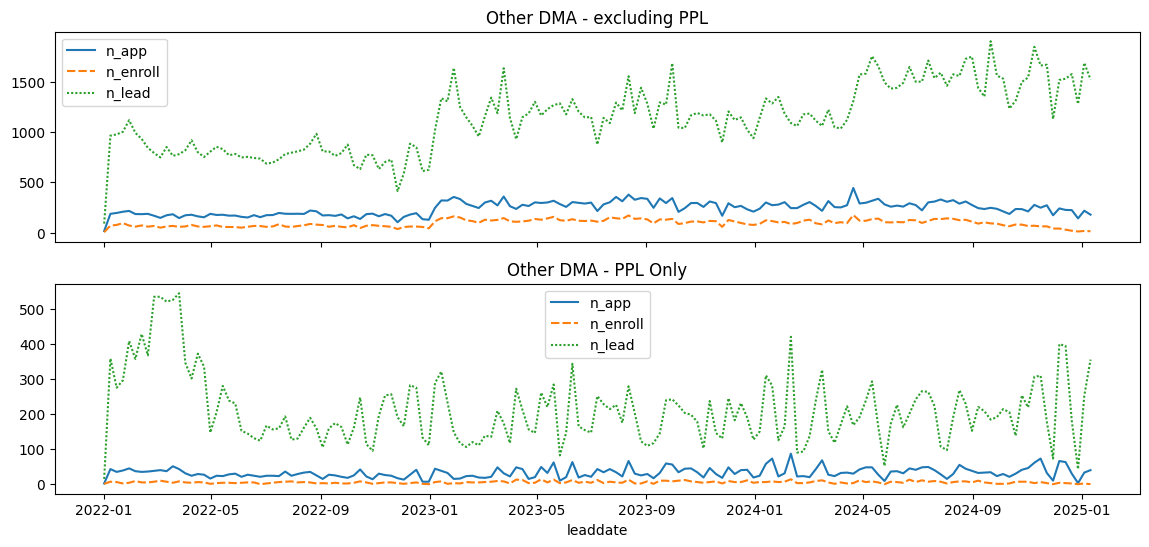

In [56]:
fig, axes = plt.subplots(2,1, figsize=(14,6), sharex=True)
sns.lineplot(data=df_kpi_cohort_weekly.loc[:, ('other', 'ALL(No PPL,Referral)')], ax=axes[0])
sns.lineplot(data=df_kpi_cohort_weekly.loc[:, ('other', 'PPL')], ax=axes[1])
axes[0].set_title('Other DMA - excluding PPL')
axes[1].set_title('Other DMA - PPL Only');